We need two things for generating coexpression proxies for a new species, single cell data and an orthology relationship. This template helps generate a coexpression network, but the orthology relationship will need to come from another existing tool. 

In [188]:
import pandas as pd
import scanpy as sc
import anndata as ad
import h5py
import CococoNet_reader
import numpy as np
import anndata
import itertools

import Go_annotations
import seaborn as sns
import matplotlib.pyplot as plt
sc.settings.verbosity = 3  
sc.set_figure_params(facecolor = 'white', figsize = (10,8))

In [189]:
shoot_ad = ad.read_h5ad('/data/passala/Generated_Tables/Sunil_root_shoot_project/Anndata_storage/integrated_root_shoot.h5ad')


In [190]:
single_cell_arabidopsis_root = shoot_ad

Here, we do basic filtering. This dataset is older, so higher thresholds are likely more appropriate for your data. 

In [191]:
sc.pp.filter_cells(single_cell_arabidopsis_root, min_genes=200)
sc.pp.filter_genes(single_cell_arabidopsis_root, min_cells=3)

filtered out 124 genes that are detected in less than 3 cells


Here, we identify and visualize our data to pick highly variable genes. Refer to the Scanpy tutorial for more info on this. 

In [192]:
sc.pp.highly_variable_genes(single_cell_arabidopsis_root, min_mean=0.125, max_mean=4, min_disp=0.25)


extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


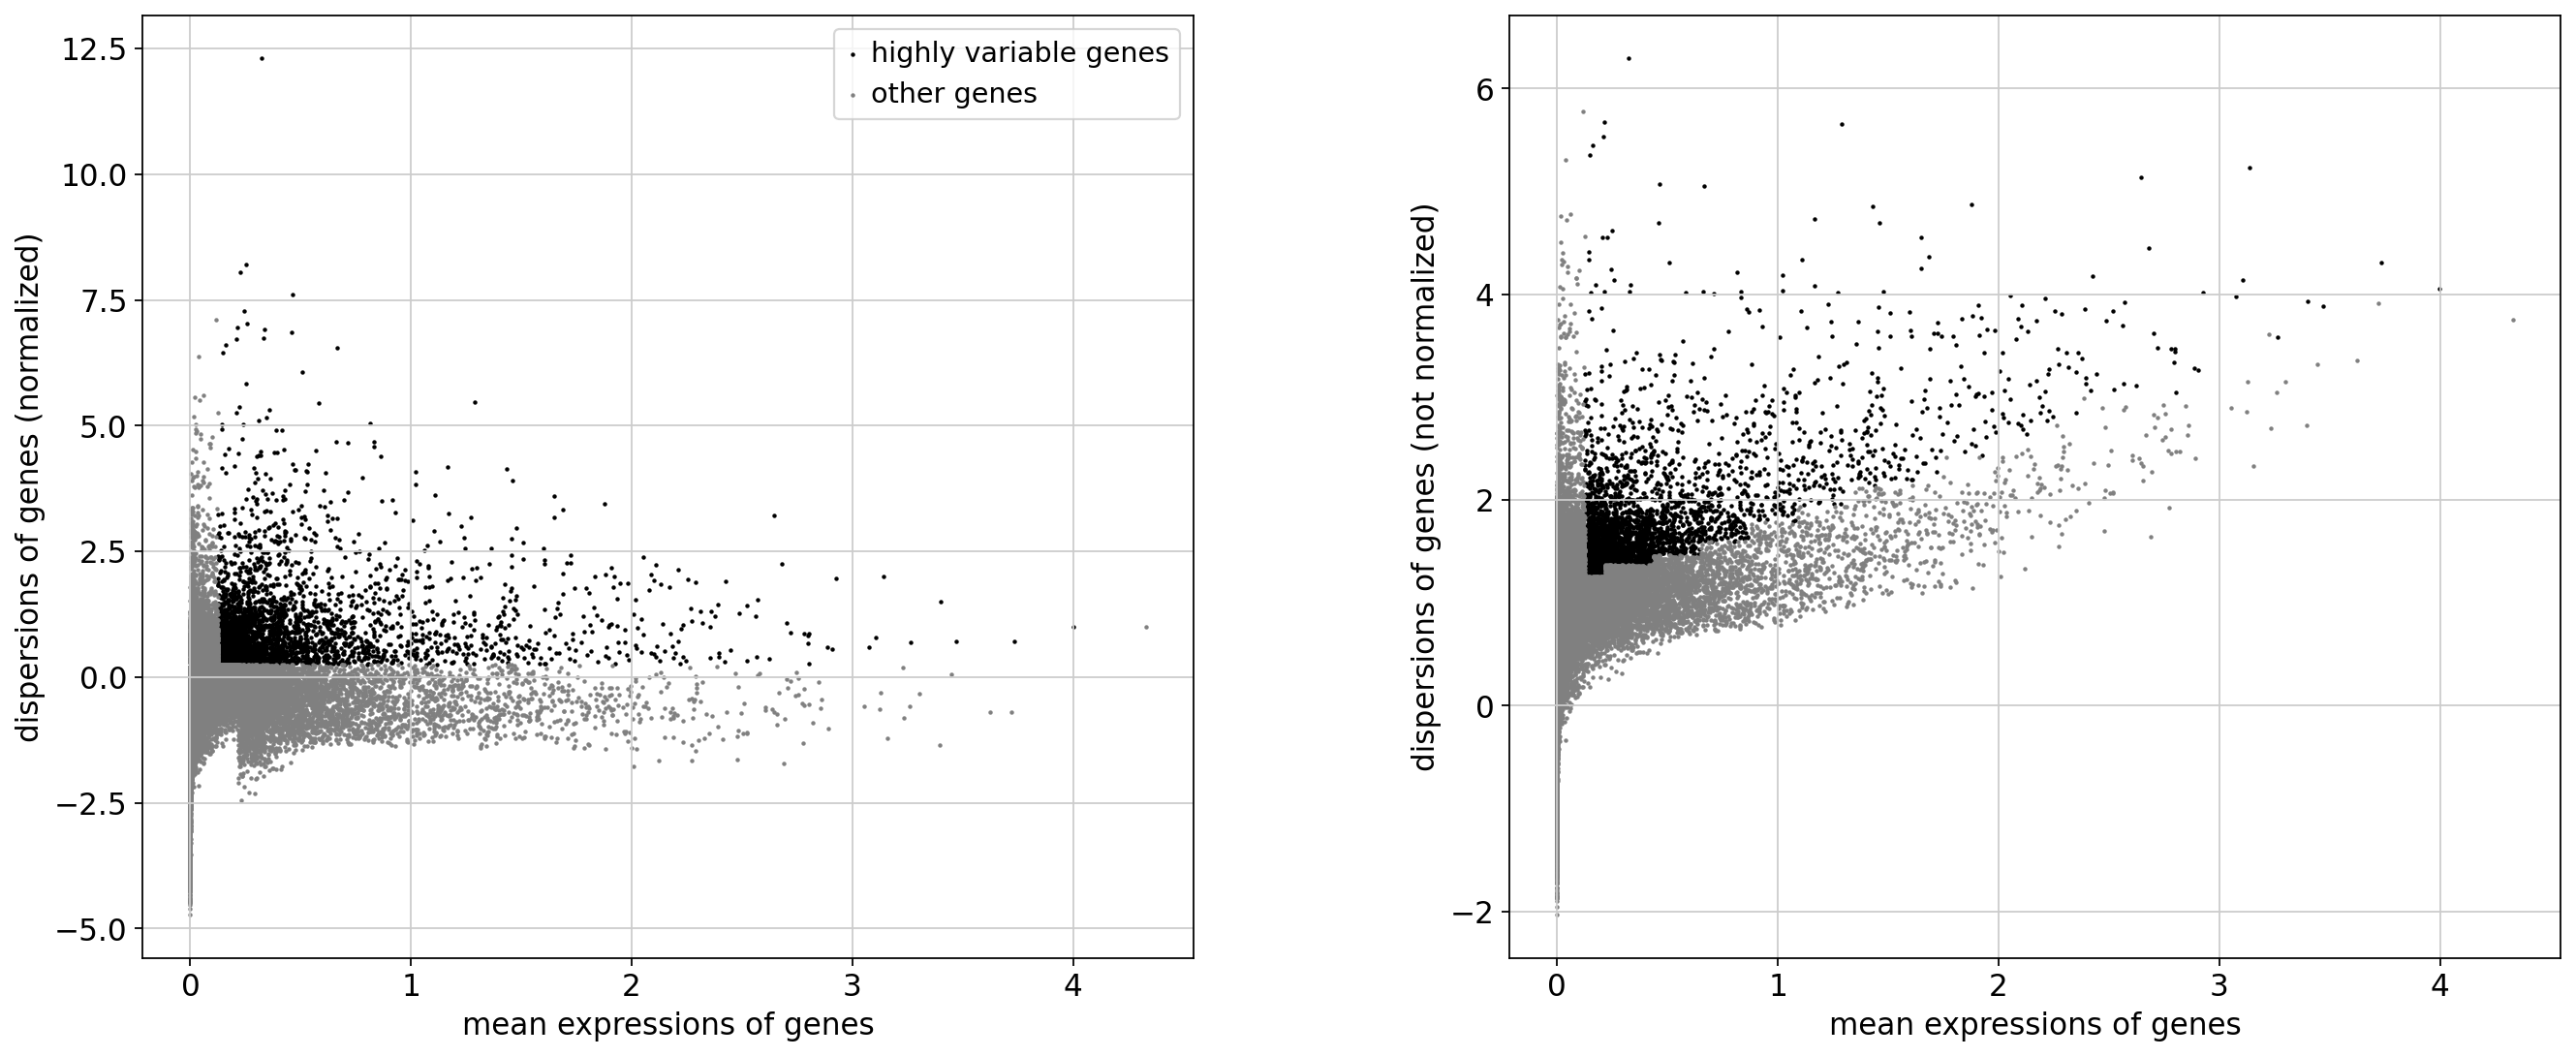

In [193]:
sc.pl.highly_variable_genes(single_cell_arabidopsis_root)


Next, we do standard preprocessing for clustering.

In [194]:
sc.tl.pca(single_cell_arabidopsis_root, svd_solver='arpack', random_state=123)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)


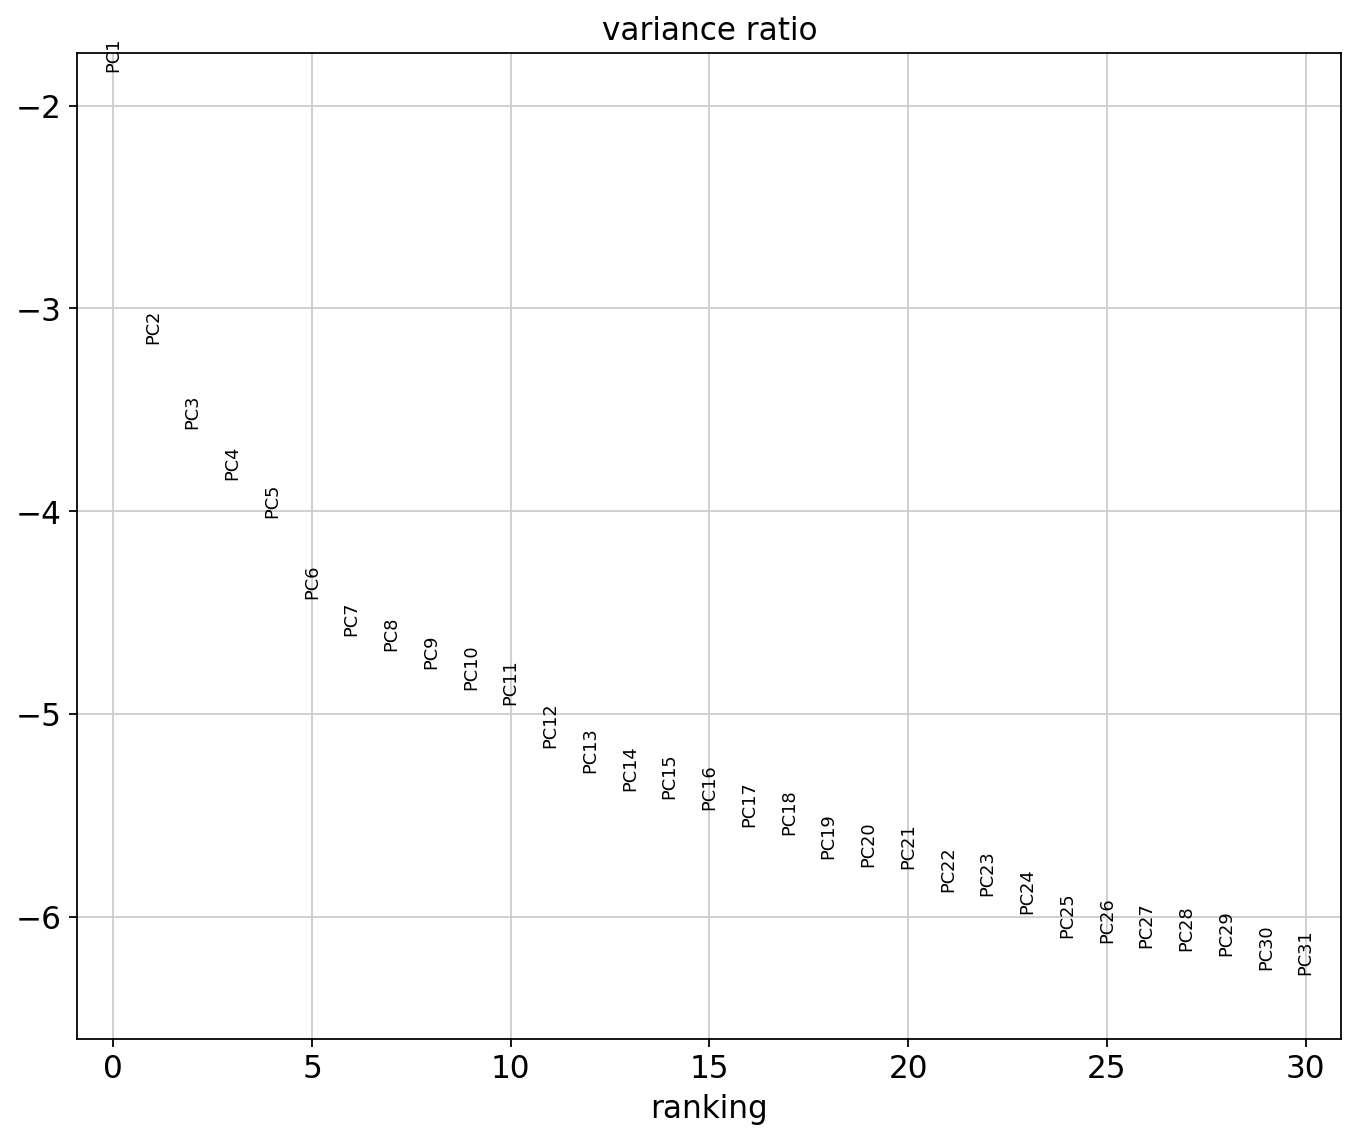

In [195]:
sc.pl.pca_variance_ratio(single_cell_arabidopsis_root, log=True)


In [196]:
sc.pp.neighbors(single_cell_arabidopsis_root, n_neighbors=12, n_pcs=50)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [197]:
sc.tl.umap(single_cell_arabidopsis_root, random_state = 156)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


In [198]:
single_cell_arabidopsis_root.obs

orig.ident  nCount_RNA  nFeature_RNA  \
index                                                     
AAACCTGCAAACTGCT_1     Inflo1        1451          1114   
AAACCTGGTTACGTCA_1     Inflo1        4442          2468   
AAACCTGTCCGCGTTT_1     Inflo1        1572           965   
AAACGGGAGATATGCA_1     Inflo1        1899          1304   
AAACGGGCATCCAACA_1     Inflo1        1485          1081   
...                       ...         ...           ...   
TTTGGTTAGGTTTACC_9      Root9        4756          2317   
TTTGTTGCAGTCAGTT_9      Root9       19949          4231   
TTTGTTGCATTGACTG_9      Root9       33151          6570   
TTTGTTGGTCAACGCC_9      Root9       24224          4926   
TTTGTTGGTCACTCAA_9      Root9        7760          2349   

                    integrated_snn_res.0.5  seurat_clusters  \
index                                                         
AAACCTGCAAACTGCT_1                      11                9   
AAACCTGGTTACGTCA_1                       2                1   
AAACCTGTCCGCGTTT_1                       2                1   
AAACGGGAGATATGCA_1                       7                6   
AAACGGGCATCCAACA_1                      11                9   
...                                    ...              ...   
TTTGGTTAGGTTTACC_9                       0                2   
TTTGTTGCAGTCAGTT_9                      12               15   
TTTGTTGCATTGACTG_9                       3                3   
TTTGTTGGTCAACGCC_9                       5               14   
TTTGTTGGTCACTCAA_9                       6                7   

                    integrated_snn_res.0.6  integrated_snn_res.0.7  \
index                                                                
AAACCTGCAAACTGCT_1                      10                       9   
AAACCTGGTTACGTCA_1                       2                       1   
AAACCTGTCCGCGTTT_1                       2                       1   
AAACGGGAGATATGCA_1                       6                       6   
AAACGGGCATCCAACA_1                      10                       9   
...                                    ...                     ...   
TTTGGTTAGGTTTACC_9                       1                       2   
TTTGTTGCAGTCAGTT_9                      11                      15   
TTTGTTGCATTGACTG_9                       5                       3   
TTTGTTGGTCAACGCC_9                      16                      14   
TTTGTTGGTCACTCAA_9                       4                       7   

                   orig.ident2           Barcode             CellType  n_genes  
index                                                                           
AAACCTGCAAACTGCT_1       inflo  AAACCTGCAAACTGCT  6_meristem_boundary     1114  
AAACCTGGTTACGTCA_1       inflo  AAACCTGGTTACGTCA            4_S-phase     2468  
AAACCTGTCCGCGTTT_1       inflo  AAACCTGTCCGCGTTT            4_S-phase      965  
AAACGGGAGATATGCA_1       inflo  AAACGGGAGATATGCA             0_cortex     1304  
AAACGGGCATCCAACA_1       inflo  AAACGGGCATCCAACA  6_meristem_boundary     1081  
...                        ...               ...                  ...      ...  
TTTGGTTAGGTTTACC_9        root  TTTGGTTAGGTTTACC         13_epidermis     2317  
TTTGTTGCAGTCAGTT_9        root  TTTGTTGCAGTCAGTT             6_phloem     4231  
TTTGTTGCATTGACTG_9        root  TTTGTTGCATTGACTG          7_pericycle     6570  
TTTGTTGGTCAACGCC_9        root  TTTGTTGGTCAACGCC              0_stele     4926  
TTTGTTGGTCACTCAA_9        root  TTTGTTGGTCACTCAA   18_pericycle/stele     2349  

[29255 rows x 11 columns]

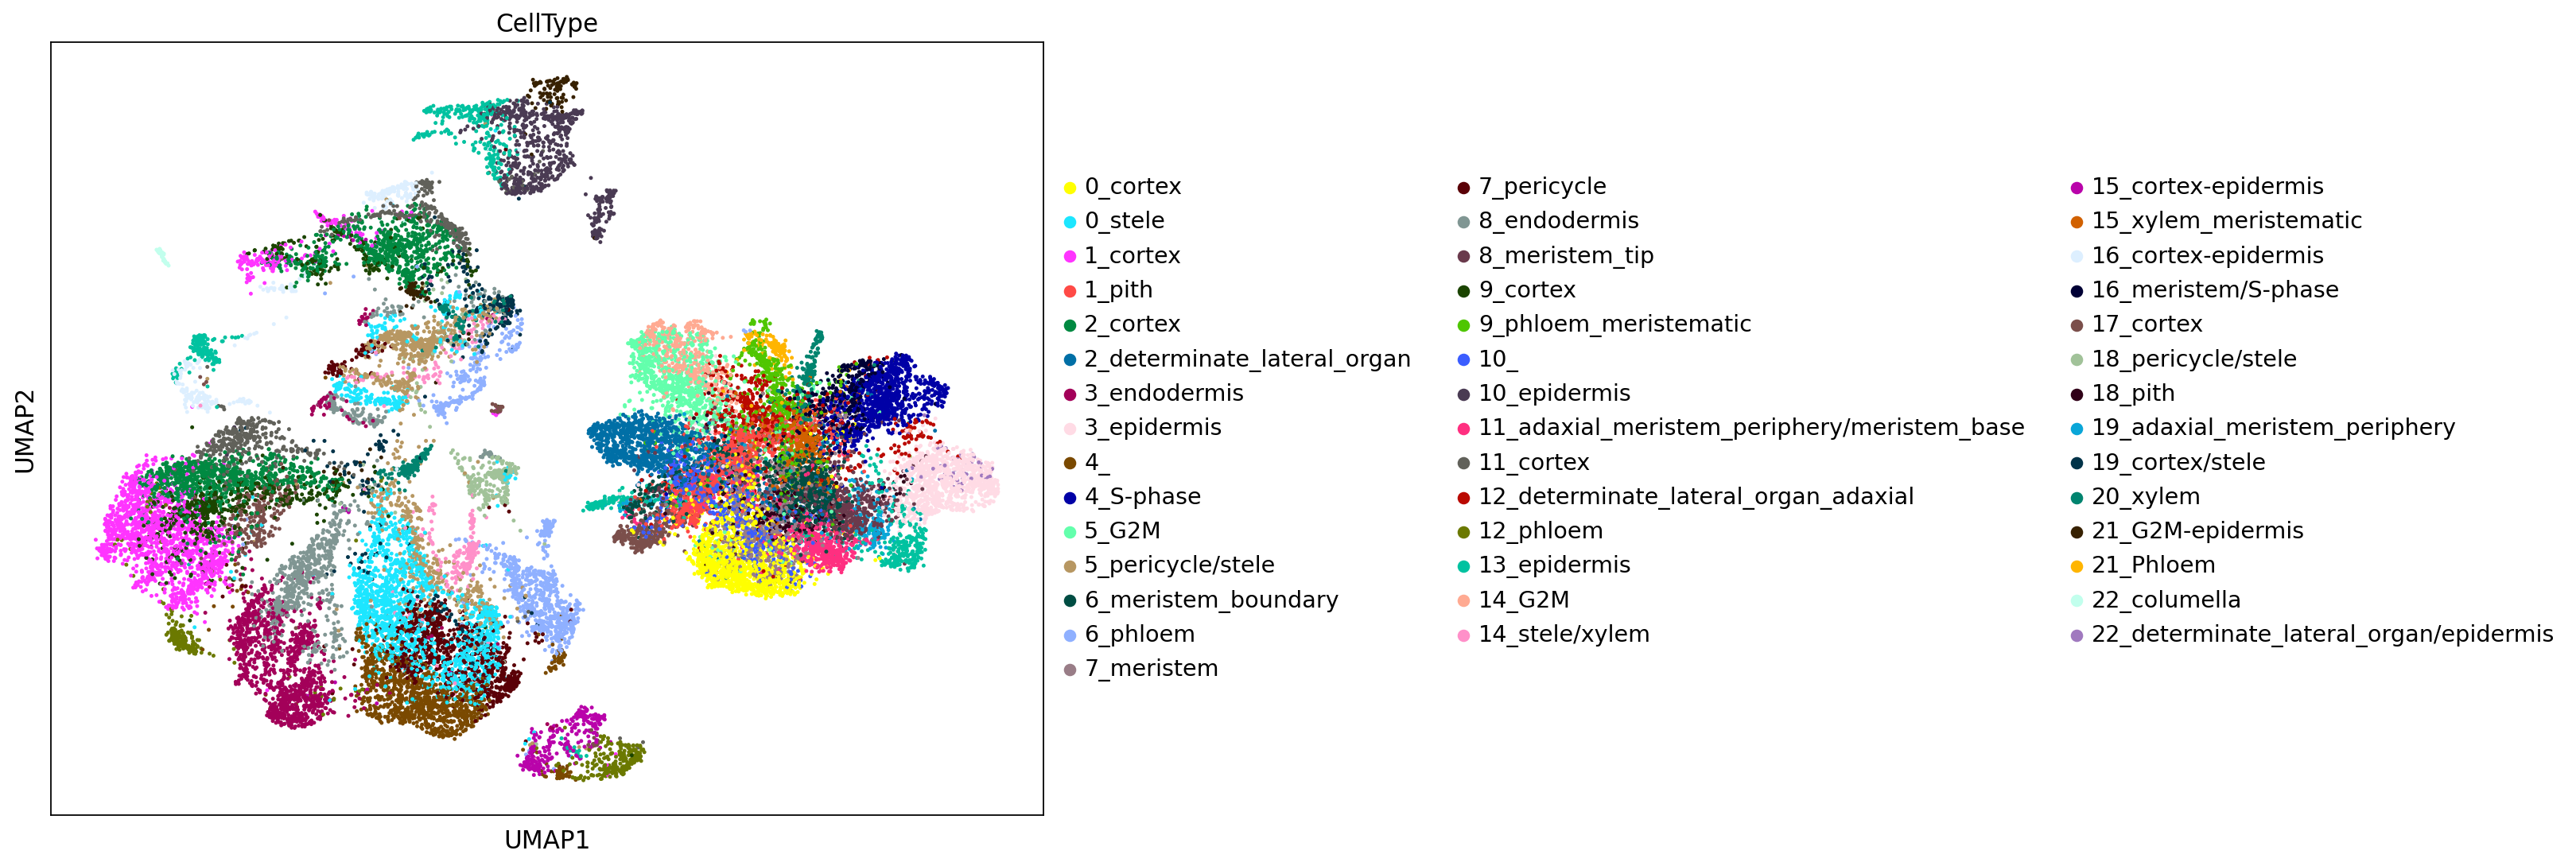

In [199]:
sc.pl.umap(single_cell_arabidopsis_root,color = 'CellType', s = 20)

Here, we majorly diverge from a standard clustering pipeline. We want to pick a resolution such that we have several hundred clusters, and that most clusters have low double digit numbers of cells. This resolution will probably be ridiculously high, in the 50-200 range. 

In [200]:
sc.tl.leiden(single_cell_arabidopsis_root,resolution = 150, random_state = 233)

running Leiden clustering
    finished: found 1532 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)


Check how many cells are in biggest and smallest clusters

In [201]:
single_cell_arabidopsis_root.obs['leiden'].value_counts().head(20)

0     53
1     52
2     47
3     45
4     43
5     42
6     42
7     42
8     41
9     41
10    41
11    41
13    40
12    40
14    39
15    39
16    39
17    39
18    38
19    38
Name: leiden, dtype: int64

In [202]:
single_cell_arabidopsis_root.obs['leiden'].value_counts().tail(20)

1517    5
1516    5
1512    5
1514    5
1511    5
1510    5
1509    5
1508    5
1507    5
1506    5
1513    5
1526    4
1528    4
1527    4
1523    4
1525    4
1524    4
1529    3
1530    3
1531    3
Name: leiden, dtype: int64

In [203]:
single_cell_arabidopsis_root

AnnData object with n_obs × n_vars = 29255 × 29655
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.5', 'seurat_clusters', 'integrated_snn_res.0.6', 'integrated_snn_res.0.7', 'orig.ident2', 'Barcode', 'CellType', 'n_genes', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'CellType_colors', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Now, we are going to psuedobulk our samples, averaging expression within each tiny cluster

In [204]:
psuedobulk_df = pd.DataFrame(index = single_cell_arabidopsis_root.var_names)## Make a base dataframe index we will add stuff on to later
all_samples = list(single_cell_arabidopsis_root.obs.leiden.unique())  ## get list of clusters to loop through
psuedobulk_df

Empty DataFrame
Columns: []
Index: [Zm00001eb026490, Zm00001eb056070, Zm00001eb055450, Zm00001eb053570, Zm00001eb004770, Zm00001eb036750, Zm00001eb013610, Zm00001eb027880, Zm00001eb022970, Zm00001eb048840, Zm00001eb004570, Zm00001eb058260, Zm00001eb053860, Zm00001eb035520, Zm00001eb037360, Zm00001eb054430, Zm00001eb033910, Zm00001eb050460, Zm00001eb030870, Zm00001eb063860, Zm00001eb033480, Zm00001eb017780, Zm00001eb040490, Zm00001eb002760, Zm00001eb009290, Zm00001eb016540, Zm00001eb058570, Zm00001eb052590, Zm00001eb065340, Zm00001eb052950, Zm00001eb059800, Zm00001eb059560, Zm00001eb038130, Zm00001eb063280, Zm00001eb057150, Zm00001eb013450, Zm00001eb014970, Zm00001eb023690, Zm00001eb005010, Zm00001eb021900, Zm00001eb059210, Zm00001eb048230, Zm00001eb042590, Zm00001eb049880, Zm00001eb036320, Zm00001eb062570, Zm00001eb064390, Zm00001eb000190, Zm00001eb019130, Zm00001eb020150, Zm00001eb024550, Zm00001eb056660, Zm00001eb013060, Zm00001eb062910, Zm00001eb020370, Zm00001eb019210, Zm00001eb044090, Zm00001eb019470, Zm00001eb051310, Zm00001eb063610, Zm00001eb060720, Zm00001eb003890, Zm00001eb064850, Zm00001eb061570, Zm00001eb061140, Zm00001eb060260, Zm00001eb057920, Zm00001eb042030, Zm00001eb008620, Zm00001eb001630, Zm00001eb018590, Zm00001eb016850, Zm00001eb018830, Zm00001eb035990, Zm00001eb042260, Zm00001eb057740, Zm00001eb032280, Zm00001eb020330, Zm00001eb062310, Zm00001eb017430, Zm00001eb008850, Zm00001eb015100, Zm00001eb021880, Zm00001eb003480, Zm00001eb056620, Zm00001eb063090, Zm00001eb013860, Zm00001eb020140, Zm00001eb065550, Zm00001eb052270, Zm00001eb054120, Zm00001eb049300, Zm00001eb021050, Zm00001eb043730, Zm00001eb030630, Zm00001eb001460, Zm00001eb064340, Zm00001eb059910, Zm00001eb028980, Zm00001eb012750, ...]

[29655 rows x 0 columns]

In [205]:
len(all_samples)

1532

Below we actually do the psuedobulk.

In [206]:
for batch_type in all_samples:

    ## Read in the Names so our code is easy to understand
    current_cluster = batch_type

    ## Calculate the Psuedobulked mean
    cells_matching_batch_and_cluster = single_cell_arabidopsis_root[single_cell_arabidopsis_root.obs['leiden'] == current_cluster ]
    mean_of_genes = cells_matching_batch_and_cluster.X.mean(axis = 0).tolist()


    name_of_combo = current_cluster
    psuedobulk_df[name_of_combo] = mean_of_genes

/tmp/ipykernel_1392734/3573879276.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  psuedobulk_df[name_of_combo] = mean_of_genes
/tmp/ipykernel_1392734/3573879276.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  psuedobulk_df[name_of_combo] = mean_of_genes
/tmp/ipykernel_1392734/3573879276.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-

In [207]:
psuedobulk_df

859       666       319       697       959       261  \
Zm00001eb026490  0.000000  0.000000  0.082406  0.117887  0.000000  0.124583   
Zm00001eb056070  0.000000  0.051893  0.049401  0.000000  0.000000  0.000000   
Zm00001eb055450  0.000000  0.046452  0.228498  0.079178  0.114862  0.034169   
Zm00001eb053570  0.121202  0.163723  0.049401  0.106419  0.091887  0.057047   
Zm00001eb004770  0.000000  0.050222  0.000000  0.119480  0.122780  0.000000   
...                   ...       ...       ...       ...       ...       ...   
Zm00001eb426870  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Zm00001eb413570  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Zm00001eb416910  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Zm00001eb438410  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Zm00001eb442470  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                      760       428       609        33  ...       533  \
Zm00001eb026490  0.138629  0.000000  0.095826  0.094254  ...  0.000000   
Zm00001eb056070  0.000000  0.000000  0.000000  0.000000  ...  0.059022   
Zm00001eb055450  0.133440  0.357466  0.000000  0.041563  ...  0.017399   
Zm00001eb053570  0.217088  0.000000  0.000000  0.042071  ...  0.524508   
Zm00001eb004770  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
...                   ...       ...       ...       ...  ...       ...   
Zm00001eb426870  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
Zm00001eb413570  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
Zm00001eb416910  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
Zm00001eb438410  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
Zm00001eb442470  0.000000  0.000000  0.000000  0.000000  ...  0.000000   

                     1374      1046      1467       286      1340       551  \
Zm00001eb026490  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Zm00001eb056070  0.082748  0.000000  0.063234  0.072670  0.018258  0.000000   
Zm00001eb055450  0.031951  0.170638  0.031168  0.059146  0.000000  0.039816   
Zm00001eb053570  0.238226  0.464316  0.451092  0.436168  0.640748  0.614215   
Zm00001eb004770  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                   ...       ...       ...       ...       ...       ...   
Zm00001eb426870  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Zm00001eb413570  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Zm00001eb416910  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Zm00001eb438410  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Zm00001eb442470  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                      689      1479      1530  
Zm00001eb026490  0.000000  0.000000  0.000000  
Zm00001eb056070  0.212759  0.000000  0.202959  
Zm00001eb055450  0.015244  0.046512  0.000000  
Zm00001eb053570  0.276974  0.730311  0.202959  
Zm00001eb004770  0.000000  0.000000  0.000000  
...                   ...       ...       ...  
Zm00001eb426870  0.000000  0.000000  0.000000  
Zm00001eb413570  0.000000  0.000000  0.000000  
Zm00001eb416910  0.000000  0.000000  0.000000  
Zm00001eb438410  0.000000  0.000000  0.000000  
Zm00001eb442470  0.000000  0.000000  0.000000  

[29655 rows x 1532 columns]

In [208]:
exp_data = psuedobulk_df

Next, we efficiently generate the spearman coexpression matrix, should be faster than .corr

In [209]:
import numpy as np
import scipy.stats as sci

rank_test_py_exp = sci.rankdata(exp_data, method = 'average', axis = 1)                #Row ranks
rank_test_py_exp = rank_test_py_exp - rank_test_py_exp.mean(axis = 1)[1]               #Center each gene, subtract mean rank
rank_test_py_exp_2 = np.square(rank_test_py_exp)                                       #Square
rank_test_py_exp = rank_test_py_exp /np.sqrt(rank_test_py_exp_2.sum(axis = 1))[:,None] #divide by sqrt(rowSums)
cr_python = np.dot(rank_test_py_exp, rank_test_py_exp.T)                               # Get correlations

In [210]:
cr_python

array([[ 1.        , -0.41861732,  0.13012624, ..., -0.04061194,
        -0.04061194, -0.03515949],
       [-0.41861732,  1.        , -0.02460452, ...,  0.00445122,
         0.03582514,  0.02733835],
       [ 0.13012624, -0.02460452,  1.        , ...,  0.00159907,
         0.01162287,  0.01675991],
       ...,
       [-0.04061194,  0.00445122,  0.00159907, ...,  1.        ,
        -0.0026178 , -0.00226634],
       [-0.04061194,  0.03582514,  0.01162287, ..., -0.0026178 ,
         1.        , -0.00226634],
       [-0.03515949,  0.02733835,  0.01675991, ..., -0.00226634,
        -0.00226634,  1.        ]])

Put the results in a labeled dataframe, and this is your coexpression network!

In [211]:
corr_results = pd.DataFrame(columns = psuedobulk_df.index, index = psuedobulk_df.index, data = cr_python)
corr_results

Zm00001eb026490  Zm00001eb056070  Zm00001eb055450  \
Zm00001eb026490         1.000000        -0.418617         0.130126   
Zm00001eb056070        -0.418617         1.000000        -0.024605   
Zm00001eb055450         0.130126        -0.024605         1.000000   
Zm00001eb053570        -0.480027         0.701665        -0.021180   
Zm00001eb004770         0.154438        -0.119663         0.081757   
...                          ...              ...              ...   
Zm00001eb426870        -0.014618         0.029146        -0.008021   
Zm00001eb413570        -0.035159         0.007647        -0.008290   
Zm00001eb416910        -0.040612         0.004451         0.001599   
Zm00001eb438410        -0.040612         0.035825         0.011623   
Zm00001eb442470        -0.035159         0.027338         0.016760   

                 Zm00001eb053570  Zm00001eb004770  Zm00001eb036750  \
Zm00001eb026490        -0.480027         0.154438        -0.050847   
Zm00001eb056070         0.701665        -0.119663         0.102236   
Zm00001eb055450        -0.021180         0.081757         0.032210   
Zm00001eb053570         1.000000        -0.150283         0.081582   
Zm00001eb004770        -0.150283         1.000000         0.059575   
...                          ...              ...              ...   
Zm00001eb426870         0.041392        -0.020629        -0.022418   
Zm00001eb413570         0.035582        -0.020629        -0.026651   
Zm00001eb416910         0.067848        -0.023828        -0.061496   
Zm00001eb438410         0.054930        -0.023828        -0.049833   
Zm00001eb442470         0.045080         0.011145        -0.043857   

                 Zm00001eb013610  Zm00001eb027880  Zm00001eb022970  \
Zm00001eb026490         0.056874         0.014535         0.231977   
Zm00001eb056070        -0.004078        -0.033744        -0.205225   
Zm00001eb055450         0.032054         0.092306         0.086408   
Zm00001eb053570         0.011283        -0.034853        -0.278972   
Zm00001eb004770         0.076291         0.050060         0.146210   
...                          ...              ...              ...   
Zm00001eb426870         0.014248         0.005193        -0.021116   
Zm00001eb413570         0.045765         0.007915        -0.021116   
Zm00001eb416910        -0.037849         0.041808        -0.024390   
Zm00001eb438410         0.000107         0.036539        -0.024390   
Zm00001eb442470         0.012733         0.021103        -0.021116   

                 Zm00001eb048840  ...  Zm00001eb424730  Zm00001eb415990  \
Zm00001eb026490         0.207968  ...        -0.035159        -0.017983   
Zm00001eb056070        -0.109957  ...         0.016496         0.042366   
Zm00001eb055450         0.119447  ...        -0.033142        -0.019691   
Zm00001eb053570        -0.143220  ...         0.021643         0.051294   
Zm00001eb004770         0.087312  ...        -0.020629        -0.020629   
...                          ...  ...              ...              ...   
Zm00001eb426870        -0.029071  ...        -0.001962        -0.001962   
Zm00001eb413570        -0.040985  ...        -0.001962        -0.001962   
Zm00001eb416910        -0.017575  ...        -0.002266        -0.002266   
Zm00001eb438410         0.002626  ...        -0.002266        -0.002266   
Zm00001eb442470        -0.010779  ...        -0.001962        -0.001962   

                 Zm00001eb417570  Zm00001eb417750  Zm00001eb433260  \
Zm00001eb026490        -0.049772        -0.078928        -0.053777   
Zm00001eb056070         0.039666         0.021501         0.050759   
Zm00001eb055450        -0.027718        -0.040845        -0.011478   
Zm00001eb053570         0.048395         0.072077         0.063113   
Zm00001eb004770         0.015500        -0.016560        -0.031552   
...                          ...              ...              ...   
Zm00001eb426870        -0.002777        -0.004405        -0.003001   
Zm00001eb413570        -0.002777 

In [212]:
#corr_results.to_csv('/data/passala/Generated_Tables/Sunil_root_shoot_project/integrated_root_shoot_corr_network.csv')

In [213]:
maize_real_network = CococoNet_reader.read_cococonet('maize')
maize_real_network

Zm00001d027231  Zm00001d027232  Zm00001d027233  \
Zm00001d027231         1.000000        0.078108        0.108838   
Zm00001d027232         0.078108        1.000000        0.876293   
Zm00001d027233         0.108838        0.876293        1.000000   
Zm00001d027236         0.461957        0.694633        0.670667   
Zm00001d027239         0.800930        0.214400        0.536561   
...                         ...             ...             ...   
ENSRNA049479090        0.226575        0.032805        0.015186   
ENSRNA049478822        0.207282        0.034453        0.047389   
ENSRNA049478534        0.175594        0.028501        0.013844   
ENSRNA049478530        0.204687        0.069983        0.054827   
ENSRNA049478881        0.181446        0.055660        0.073887   

                 Zm00001d027236  Zm00001d027239  Zm00001d027240  \
Zm00001d027231         0.461957        0.800930        0.319041   
Zm00001d027232         0.694633        0.214400        0.120976   
Zm00001d027233         0.670667        0.536561        0.207089   
Zm00001d027236         1.000000        0.656247        0.302919   
Zm00001d027239         0.656247        1.000000        0.457139   
...                         ...             ...             ...   
ENSRNA049479090        0.057754        0.090521        0.100821   
ENSRNA049478822        0.107408        0.056203        0.110707   
ENSRNA049478534        0.058877        0.156326        0.145373   
ENSRNA049478530        0.062916        0.082495        0.110693   
ENSRNA049478881        0.111273        0.167994        0.118315   

                 Zm00001d027242  Zm00001d027248  Zm00001d027253  \
Zm00001d027231         0.760313        0.660045        0.359478   
Zm00001d027232         0.026657        0.382087        0.287655   
Zm00001d027233         0.146332        0.328618        0.438306   
Zm00001d027236         0.200345        0.460549        0.135278   
Zm00001d027239         0.921456        0.095157        0.205044   
...                         ...             ...             ...   
ENSRNA049479090        0.150854        0.062272        0.111443   
ENSRNA049478822        0.080529        0.061199        0.056742   
ENSRNA049478534        0.157355        0.106117        0.138546   
ENSRNA049478530        0.165403        0.207660        0.066610   
ENSRNA049478881        0.171111        0.095529        0.119147   

                 Zm00001d027254  ...  ENSRNA049478584  ENSRNA049478607  \
Zm00001d027231         0.588317  ...         0.200135         0.149610   
Zm00001d027232         0.447700  ...         0.078462         0.039292   
Zm00001d027233         0.540782  ...         0.037824         0.038944   
Zm00001d027236         0.479839  ...         0.044842         0.012275   
Zm00001d027239         0.489878  ...         0.131221         0.093305   
...                         ...  ...              ...              ...   
ENSRNA049479090        0.113159  ...         0.967584         0.893915   
ENSRNA049478822        0.055877  ...         0.946128         0.900723   
ENSRNA049478534        0.235968  ...         0.972773         0.914726   
ENSRNA049478530        0.087071  ...         0.992406         0.935132   
ENSRNA049478881        0.100034  ...         0.965560         0.912690   

                 ENSRNA049478600  Zm00001d000447  Zm00001d000452  \
Zm00001d027231          0.229181        0.073480        0.382390   
Zm00001d027232          0.145391        0.032343        0.135960   
Zm00001d027233          0.072977        0.011442        0.277296   
Zm00001d027236          0.142607        0.149006        0.417343   
Zm00001d027239          0.128835        0.103421        0.667229   
...                          ...             ...             ...   
ENSRNA049479090         0.957201        0.048170        0.045550   
ENSRNA049478822         0.943176        0.043434        0.028705   
ENSRNA049478534         0.980563        0.119946        0.058226   
ENSRNA049478530         0.974161 

In [214]:
maize_converter = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/v3_tov4_tov5_IDs.csv')
maize_converter = maize_converter.drop_duplicates(subset = 'Gene_IDs_v4', keep = False)
maize_converter = maize_converter.drop_duplicates(subset = 'Gene_IDs_v5', keep = False)
maize_converter

Gene_IDs_v4       Gene_IDs_v3      Gene_IDs_v5
0      Zm00001d001763     GRMZM2G172529  Zm00001eb065560
3      Zm00001d001766     GRMZM5G876379  Zm00001eb065580
4      Zm00001d001767     GRMZM2G154437  Zm00001eb065610
5      Zm00001d001769     GRMZM2G013776  Zm00001eb065620
6      Zm00001d001773     GRMZM6G163181  Zm00001eb065650
...               ...               ...              ...
28339  Zm00001d054099     GRMZM2G106280  Zm00001eb210080
28344  Zm00001d054105     GRMZM2G169462  Zm00001eb210120
28345  Zm00001d054106     GRMZM2G134889  Zm00001eb210140
28346  Zm00001d054110     GRMZM2G398458  Zm00001eb210160
28347  Zm00001d054112  AC183968.2_FG001  Zm00001eb210170

[24014 rows x 3 columns]

In [215]:
convertable_maize_coconet = maize_real_network.loc[maize_real_network.index.isin(maize_converter['Gene_IDs_v4'].to_list())]
convertable_maize_coconet = convertable_maize_coconet[convertable_maize_coconet.columns.intersection(maize_converter['Gene_IDs_v4'])]
convertable_maize_coconet

Zm00001d027231  Zm00001d027240  Zm00001d027256  \
Zm00001d027231        1.000000        0.319041        0.189682   
Zm00001d027240        0.319041        1.000000        0.128286   
Zm00001d027256        0.189682        0.128286        1.000000   
Zm00001d027258        0.211864        0.164414        0.304559   
Zm00001d027265        0.738875        0.613635        0.420056   
...                        ...             ...             ...   
Zm00001d026702        0.940923        0.451791        0.300839   
Zm00001d026703        0.532101        0.600144        0.467621   
Zm00001d026704        0.509944        0.438177        0.406763   
Zm00001d026705        0.851272        0.583190        0.382935   
Zm00001d026712        0.520360        0.026201        0.304628   

                Zm00001d027258  Zm00001d027265  Zm00001d027266  \
Zm00001d027231        0.211864        0.738875        0.502275   
Zm00001d027240        0.164414        0.613635        0.568020   
Zm00001d027256        0.304559        0.420056        0.471519   
Zm00001d027258        1.000000        0.289069        0.334962   
Zm00001d027265        0.289069        1.000000        0.975959   
...                        ...             ...             ...   
Zm00001d026702        0.355686        0.884287        0.863095   
Zm00001d026703        0.521031        0.890474        0.840666   
Zm00001d026704        0.367569        0.888578        0.973566   
Zm00001d026705        0.273646        0.960592        0.927666   
Zm00001d026712        0.371753        0.619740        0.645844   

                Zm00001d027267  Zm00001d027268  Zm00001d027271  \
Zm00001d027231        0.560250        0.335229        0.530495   
Zm00001d027240        0.372448        0.157977        0.620768   
Zm00001d027256        0.548075        0.055978        0.104784   
Zm00001d027258        0.602491        0.132071        0.083857   
Zm00001d027265        0.918783        0.620455        0.859692   
...                        ...             ...             ...   
Zm00001d026702        0.911190        0.563368        0.521884   
Zm00001d026703        0.783003        0.069512        0.419785   
Zm00001d026704        0.932625        0.640484        0.679588   
Zm00001d026705        0.904763        0.533331        0.763475   
Zm00001d026712        0.713405        0.624606        0.165085   

                Zm00001d027281  ...  Zm00001d026690  Zm00001d026691  \
Zm00001d027231        0.619690  ...        0.089417        0.871928   
Zm00001d027240        0.176082  ...        0.151955        0.743788   
Zm00001d027256        0.142469  ...        0.281838        0.269548   
Zm00001d027258        0.265704  ...        0.127241        0.470987   
Zm00001d027265        0.287828  ...        0.790670        0.954452   
...                        ...  ...             ...             ...   
Zm00001d026702        0.633598  ...        0.643380        0.949011   
Zm00001d026703        0.219695  ...        0.486778        0.926616   
Zm00001d026704        0.319212  ...        0.884786        0.729678   
Zm00001d026705        0.363163  ...        0.632391        0.952804   
Zm00001d026712        0.655647  ...        0.746092        0.276533   

                Zm00001d026695  Zm00001d026698  Zm00001d026701  \
Zm00001d027231        0.124315        0.953314        0.764500   
Zm00001d027240        0.159213        0.623429        0.455449   
Zm00001d027256        0.408374        0.151907        0.227695   
Zm00001d027258        0.453389        0.262552        0.469042   
Zm00001d027265        0.816026        0.955189        0.937292   
...                        ...             ...             ...   
Zm00001d026702        0.718305        0.989202        0.980804   
Zm00001d026703        0.785668        0.885685        0.893707   
Zm00001d026704        0.887748        0.692138        0.828260   
Zm00001d026705        0.722512        0.948375        0.866998   
Zm00001d026712        0.723489        0.450933        0.76

In [216]:
convert_dict = pd.Series(maize_converter['Gene_IDs_v5'].values,index=maize_converter['Gene_IDs_v4']).to_dict()

In [217]:
convertable_maize_coconet = convertable_maize_coconet.rename(axis =0, mapper = convert_dict)
convertable_maize_coconet

Zm00001d027231  Zm00001d027240  Zm00001d027256  \
Zm00001eb000020        1.000000        0.319041        0.189682   
Zm00001eb000070        0.319041        1.000000        0.128286   
Zm00001eb000180        0.189682        0.128286        1.000000   
Zm00001eb000200        0.211864        0.164414        0.304559   
Zm00001eb000210        0.738875        0.613635        0.420056   
...                         ...             ...             ...   
Zm00001eb434510        0.940923        0.451791        0.300839   
Zm00001eb434520        0.532101        0.600144        0.467621   
Zm00001eb434530        0.509944        0.438177        0.406763   
Zm00001eb434540        0.851272        0.583190        0.382935   
Zm00001eb434590        0.520360        0.026201        0.304628   

                 Zm00001d027258  Zm00001d027265  Zm00001d027266  \
Zm00001eb000020        0.211864        0.738875        0.502275   
Zm00001eb000070        0.164414        0.613635        0.568020   
Zm00001eb000180        0.304559        0.420056        0.471519   
Zm00001eb000200        1.000000        0.289069        0.334962   
Zm00001eb000210        0.289069        1.000000        0.975959   
...                         ...             ...             ...   
Zm00001eb434510        0.355686        0.884287        0.863095   
Zm00001eb434520        0.521031        0.890474        0.840666   
Zm00001eb434530        0.367569        0.888578        0.973566   
Zm00001eb434540        0.273646        0.960592        0.927666   
Zm00001eb434590        0.371753        0.619740        0.645844   

                 Zm00001d027267  Zm00001d027268  Zm00001d027271  \
Zm00001eb000020        0.560250        0.335229        0.530495   
Zm00001eb000070        0.372448        0.157977        0.620768   
Zm00001eb000180        0.548075        0.055978        0.104784   
Zm00001eb000200        0.602491        0.132071        0.083857   
Zm00001eb000210        0.918783        0.620455        0.859692   
...                         ...             ...             ...   
Zm00001eb434510        0.911190        0.563368        0.521884   
Zm00001eb434520        0.783003        0.069512        0.419785   
Zm00001eb434530        0.932625        0.640484        0.679588   
Zm00001eb434540        0.904763        0.533331        0.763475   
Zm00001eb434590        0.713405        0.624606        0.165085   

                 Zm00001d027281  ...  Zm00001d026690  Zm00001d026691  \
Zm00001eb000020        0.619690  ...        0.089417        0.871928   
Zm00001eb000070        0.176082  ...        0.151955        0.743788   
Zm00001eb000180        0.142469  ...        0.281838        0.269548   
Zm00001eb000200        0.265704  ...        0.127241        0.470987   
Zm00001eb000210        0.287828  ...        0.790670        0.954452   
...                         ...  ...             ...             ...   
Zm00001eb434510        0.633598  ...        0.643380        0.949011   
Zm00001eb434520        0.219695  ...        0.486778        0.926616   
Zm00001eb434530        0.319212  ...        0.884786        0.729678   
Zm00001eb434540        0.363163  ...        0.632391        0.952804   
Zm00001eb434590        0.655647  ...        0.746092        0.276533   

                 Zm00001d026695  Zm00001d026698  Zm00001d026701  \
Zm00001eb000020        0.124315        0.953314        0.764500   
Zm00001eb000070        0.159213        0.623429        0.455449   
Zm00001eb000180        0.408374        0.151907        0.227695   
Zm00001eb000200        0.453389        0.262552        0.469042   
Zm00001eb000210        0.816026        0.955189        0.937292   
...                         ...             ...             ...   
Zm00001eb434510        0.718305        0.989202        0.980804   
Zm00001eb434520        0.785668        0.885685        0.893707   
Zm00001eb434530        0.887748        0.692138        0.828260   
Zm00001eb434540        0.722512        0.948375        0.866998   


In [218]:
convertable_maize_coconet = convertable_maize_coconet.rename(axis = 1, mapper = convert_dict)
convertable_maize_coconet

Zm00001eb000020  Zm00001eb000070  Zm00001eb000180  \
Zm00001eb000020         1.000000         0.319041         0.189682   
Zm00001eb000070         0.319041         1.000000         0.128286   
Zm00001eb000180         0.189682         0.128286         1.000000   
Zm00001eb000200         0.211864         0.164414         0.304559   
Zm00001eb000210         0.738875         0.613635         0.420056   
...                          ...              ...              ...   
Zm00001eb434510         0.940923         0.451791         0.300839   
Zm00001eb434520         0.532101         0.600144         0.467621   
Zm00001eb434530         0.509944         0.438177         0.406763   
Zm00001eb434540         0.851272         0.583190         0.382935   
Zm00001eb434590         0.520360         0.026201         0.304628   

                 Zm00001eb000200  Zm00001eb000210  Zm00001eb000220  \
Zm00001eb000020         0.211864         0.738875         0.502275   
Zm00001eb000070         0.164414         0.613635         0.568020   
Zm00001eb000180         0.304559         0.420056         0.471519   
Zm00001eb000200         1.000000         0.289069         0.334962   
Zm00001eb000210         0.289069         1.000000         0.975959   
...                          ...              ...              ...   
Zm00001eb434510         0.355686         0.884287         0.863095   
Zm00001eb434520         0.521031         0.890474         0.840666   
Zm00001eb434530         0.367569         0.888578         0.973566   
Zm00001eb434540         0.273646         0.960592         0.927666   
Zm00001eb434590         0.371753         0.619740         0.645844   

                 Zm00001eb000230  Zm00001eb000240  Zm00001eb000270  \
Zm00001eb000020         0.560250         0.335229         0.530495   
Zm00001eb000070         0.372448         0.157977         0.620768   
Zm00001eb000180         0.548075         0.055978         0.104784   
Zm00001eb000200         0.602491         0.132071         0.083857   
Zm00001eb000210         0.918783         0.620455         0.859692   
...                          ...              ...              ...   
Zm00001eb434510         0.911190         0.563368         0.521884   
Zm00001eb434520         0.783003         0.069512         0.419785   
Zm00001eb434530         0.932625         0.640484         0.679588   
Zm00001eb434540         0.904763         0.533331         0.763475   
Zm00001eb434590         0.713405         0.624606         0.165085   

                 Zm00001eb000370  ...  Zm00001eb434400  Zm00001eb434410  \
Zm00001eb000020         0.619690  ...         0.089417         0.871928   
Zm00001eb000070         0.176082  ...         0.151955         0.743788   
Zm00001eb000180         0.142469  ...         0.281838         0.269548   
Zm00001eb000200         0.265704  ...         0.127241         0.470987   
Zm00001eb000210         0.287828  ...         0.790670         0.954452   
...                          ...  ...              ...              ...   
Zm00001eb434510         0.633598  ...         0.643380         0.949011   
Zm00001eb434520         0.219695  ...         0.486778         0.926616   
Zm00001eb434530         0.319212  ...         0.884786         0.729678   
Zm00001eb434540         0.363163  ...         0.632391         0.952804   
Zm00001eb434590         0.655647  ...         0.746092         0.276533   

                 Zm00001eb434430  Zm00001eb434470  Zm00001eb434500  \
Zm00001eb000020         0.124315         0.953314         0.764500   
Zm00001eb000070         0.159213         0.623429         0.455449   
Zm00001eb000180         0.408374         0.151907         0.227695   
Zm00001eb000200         0.453389         0.262552         0.469042   
Zm00001eb000210         0.816026         0.955189         0.937292   
...                          ...              ...              ...   
Zm00001eb434510         0.718305         0.989202         0.980804   
Zm00001eb434520         0.785668 

In [219]:
trimmed_corr_results = corr_results.loc[corr_results.index.isin(convertable_maize_coconet.index)]
trimmed_corr_results = trimmed_corr_results[trimmed_corr_results.columns.intersection(convertable_maize_coconet.index)]
trimmed_corr_results

Zm00001eb026490  Zm00001eb056070  Zm00001eb055450  \
Zm00001eb026490         1.000000        -0.418617         0.130126   
Zm00001eb056070        -0.418617         1.000000        -0.024605   
Zm00001eb055450         0.130126        -0.024605         1.000000   
Zm00001eb053570        -0.480027         0.701665        -0.021180   
Zm00001eb004770         0.154438        -0.119663         0.081757   
...                          ...              ...              ...   
Zm00001eb383440        -0.035159         0.018067        -0.002601   
Zm00001eb417570        -0.049772         0.039666        -0.027718   
Zm00001eb417750        -0.078928         0.021501        -0.040845   
Zm00001eb413570        -0.035159         0.007647        -0.008290   
Zm00001eb416910        -0.040612         0.004451         0.001599   

                 Zm00001eb053570  Zm00001eb004770  Zm00001eb036750  \
Zm00001eb026490        -0.480027         0.154438        -0.050847   
Zm00001eb056070         0.701665        -0.119663         0.102236   
Zm00001eb055450        -0.021180         0.081757         0.032210   
Zm00001eb053570         1.000000        -0.150283         0.081582   
Zm00001eb004770        -0.150283         1.000000         0.059575   
...                          ...              ...              ...   
Zm00001eb383440         0.038847        -0.020629        -0.041362   
Zm00001eb417570         0.048395         0.015500        -0.056680   
Zm00001eb417750         0.072077        -0.016560        -0.106792   
Zm00001eb413570         0.035582        -0.020629        -0.026651   
Zm00001eb416910         0.067848        -0.023828        -0.061496   

                 Zm00001eb013610  Zm00001eb027880  Zm00001eb022970  \
Zm00001eb026490         0.056874         0.014535         0.231977   
Zm00001eb056070        -0.004078        -0.033744        -0.205225   
Zm00001eb055450         0.032054         0.092306         0.086408   
Zm00001eb053570         0.011283        -0.034853        -0.278972   
Zm00001eb004770         0.076291         0.050060         0.146210   
...                          ...              ...              ...   
Zm00001eb383440        -0.009712         0.022758        -0.021116   
Zm00001eb417570        -0.003296         0.032077        -0.029892   
Zm00001eb417750        -0.061713         0.050402        -0.047402   
Zm00001eb413570         0.045765         0.007915        -0.021116   
Zm00001eb416910        -0.037849         0.041808        -0.024390   

                 Zm00001eb048840  ...  Zm00001eb355340  Zm00001eb264140  \
Zm00001eb026490         0.207968  ...        -0.020286        -0.061018   
Zm00001eb056070        -0.109957  ...        -0.022839         0.022798   
Zm00001eb055450         0.119447  ...        -0.032708        -0.009694   
Zm00001eb053570        -0.143220  ...         0.012952         0.067684   
Zm00001eb004770         0.087312  ...        -0.011902        -0.035800   
...                          ...  ...              ...              ...   
Zm00001eb383440        -0.025801  ...        -0.001132         0.189801   
Zm00001eb417570         0.016308  ...        -0.001603        -0.004820   
Zm00001eb417750        -0.075946  ...        -0.002541         0.080122   
Zm00001eb413570        -0.040985  ...        -0.001132        -0.003405   
Zm00001eb416910        -0.017575  ...        -0.001308         0.163333   

                 Zm00001eb268770  Zm00001eb281300  Zm00001eb267230  \
Zm00001eb026490        -0.040612        -0.018005        -0.053777   
Zm00001eb056070         0.046051         0.042327         0.025626   
Zm00001eb055450        -0.020363        -0.007218        -0.065875   
Zm00001eb053570         0.043556         0.051735         0.026252   
Zm00001eb004770         0.003449        -0.020629        -0.031552   
...                          ...              ...              ...   
Zm00001eb383440        -0.002266        -0.001962        -0.003001   
Zm00001eb417570         0.201584 

In [220]:
trimmed_convertable_maize_coco = convertable_maize_coconet.loc[convertable_maize_coconet.index.isin(trimmed_corr_results.index)]
trimmed_convertable_maize_coco = trimmed_convertable_maize_coco[trimmed_convertable_maize_coco.columns.intersection(trimmed_corr_results.index)]
trimmed_convertable_maize_coco

Zm00001eb000020  Zm00001eb000070  Zm00001eb000180  \
Zm00001eb000020         1.000000         0.319041         0.189682   
Zm00001eb000070         0.319041         1.000000         0.128286   
Zm00001eb000180         0.189682         0.128286         1.000000   
Zm00001eb000200         0.211864         0.164414         0.304559   
Zm00001eb000210         0.738875         0.613635         0.420056   
...                          ...              ...              ...   
Zm00001eb434510         0.940923         0.451791         0.300839   
Zm00001eb434520         0.532101         0.600144         0.467621   
Zm00001eb434530         0.509944         0.438177         0.406763   
Zm00001eb434540         0.851272         0.583190         0.382935   
Zm00001eb434590         0.520360         0.026201         0.304628   

                 Zm00001eb000200  Zm00001eb000210  Zm00001eb000220  \
Zm00001eb000020         0.211864         0.738875         0.502275   
Zm00001eb000070         0.164414         0.613635         0.568020   
Zm00001eb000180         0.304559         0.420056         0.471519   
Zm00001eb000200         1.000000         0.289069         0.334962   
Zm00001eb000210         0.289069         1.000000         0.975959   
...                          ...              ...              ...   
Zm00001eb434510         0.355686         0.884287         0.863095   
Zm00001eb434520         0.521031         0.890474         0.840666   
Zm00001eb434530         0.367569         0.888578         0.973566   
Zm00001eb434540         0.273646         0.960592         0.927666   
Zm00001eb434590         0.371753         0.619740         0.645844   

                 Zm00001eb000230  Zm00001eb000240  Zm00001eb000270  \
Zm00001eb000020         0.560250         0.335229         0.530495   
Zm00001eb000070         0.372448         0.157977         0.620768   
Zm00001eb000180         0.548075         0.055978         0.104784   
Zm00001eb000200         0.602491         0.132071         0.083857   
Zm00001eb000210         0.918783         0.620455         0.859692   
...                          ...              ...              ...   
Zm00001eb434510         0.911190         0.563368         0.521884   
Zm00001eb434520         0.783003         0.069512         0.419785   
Zm00001eb434530         0.932625         0.640484         0.679588   
Zm00001eb434540         0.904763         0.533331         0.763475   
Zm00001eb434590         0.713405         0.624606         0.165085   

                 Zm00001eb000370  ...  Zm00001eb434400  Zm00001eb434410  \
Zm00001eb000020         0.619690  ...         0.089417         0.871928   
Zm00001eb000070         0.176082  ...         0.151955         0.743788   
Zm00001eb000180         0.142469  ...         0.281838         0.269548   
Zm00001eb000200         0.265704  ...         0.127241         0.470987   
Zm00001eb000210         0.287828  ...         0.790670         0.954452   
...                          ...  ...              ...              ...   
Zm00001eb434510         0.633598  ...         0.643380         0.949011   
Zm00001eb434520         0.219695  ...         0.486778         0.926616   
Zm00001eb434530         0.319212  ...         0.884786         0.729678   
Zm00001eb434540         0.363163  ...         0.632391         0.952804   
Zm00001eb434590         0.655647  ...         0.746092         0.276533   

                 Zm00001eb434430  Zm00001eb434470  Zm00001eb434500  \
Zm00001eb000020         0.124315         0.953314         0.764500   
Zm00001eb000070         0.159213         0.623429         0.455449   
Zm00001eb000180         0.408374         0.151907         0.227695   
Zm00001eb000200         0.453389         0.262552         0.469042   
Zm00001eb000210         0.816026         0.955189         0.937292   
...                          ...              ...              ...   
Zm00001eb434510         0.718305         0.989202         0.980804   
Zm00001eb434520         0.785668 

In [221]:
trimmed_corr_results.columns

Index(['Zm00001eb026490', 'Zm00001eb056070', 'Zm00001eb055450',
       'Zm00001eb053570', 'Zm00001eb004770', 'Zm00001eb036750',
       'Zm00001eb013610', 'Zm00001eb027880', 'Zm00001eb022970',
       'Zm00001eb048840',
       ...
       'Zm00001eb355340', 'Zm00001eb264140', 'Zm00001eb268770',
       'Zm00001eb281300', 'Zm00001eb267230', 'Zm00001eb383440',
       'Zm00001eb417570', 'Zm00001eb417750', 'Zm00001eb413570',
       'Zm00001eb416910'],
      dtype='object', length=18854)

In [222]:
trimmed_corr_results

Zm00001eb026490  Zm00001eb056070  Zm00001eb055450  \
Zm00001eb026490         1.000000        -0.418617         0.130126   
Zm00001eb056070        -0.418617         1.000000        -0.024605   
Zm00001eb055450         0.130126        -0.024605         1.000000   
Zm00001eb053570        -0.480027         0.701665        -0.021180   
Zm00001eb004770         0.154438        -0.119663         0.081757   
...                          ...              ...              ...   
Zm00001eb383440        -0.035159         0.018067        -0.002601   
Zm00001eb417570        -0.049772         0.039666        -0.027718   
Zm00001eb417750        -0.078928         0.021501        -0.040845   
Zm00001eb413570        -0.035159         0.007647        -0.008290   
Zm00001eb416910        -0.040612         0.004451         0.001599   

                 Zm00001eb053570  Zm00001eb004770  Zm00001eb036750  \
Zm00001eb026490        -0.480027         0.154438        -0.050847   
Zm00001eb056070         0.701665        -0.119663         0.102236   
Zm00001eb055450        -0.021180         0.081757         0.032210   
Zm00001eb053570         1.000000        -0.150283         0.081582   
Zm00001eb004770        -0.150283         1.000000         0.059575   
...                          ...              ...              ...   
Zm00001eb383440         0.038847        -0.020629        -0.041362   
Zm00001eb417570         0.048395         0.015500        -0.056680   
Zm00001eb417750         0.072077        -0.016560        -0.106792   
Zm00001eb413570         0.035582        -0.020629        -0.026651   
Zm00001eb416910         0.067848        -0.023828        -0.061496   

                 Zm00001eb013610  Zm00001eb027880  Zm00001eb022970  \
Zm00001eb026490         0.056874         0.014535         0.231977   
Zm00001eb056070        -0.004078        -0.033744        -0.205225   
Zm00001eb055450         0.032054         0.092306         0.086408   
Zm00001eb053570         0.011283        -0.034853        -0.278972   
Zm00001eb004770         0.076291         0.050060         0.146210   
...                          ...              ...              ...   
Zm00001eb383440        -0.009712         0.022758        -0.021116   
Zm00001eb417570        -0.003296         0.032077        -0.029892   
Zm00001eb417750        -0.061713         0.050402        -0.047402   
Zm00001eb413570         0.045765         0.007915        -0.021116   
Zm00001eb416910        -0.037849         0.041808        -0.024390   

                 Zm00001eb048840  ...  Zm00001eb355340  Zm00001eb264140  \
Zm00001eb026490         0.207968  ...        -0.020286        -0.061018   
Zm00001eb056070        -0.109957  ...        -0.022839         0.022798   
Zm00001eb055450         0.119447  ...        -0.032708        -0.009694   
Zm00001eb053570        -0.143220  ...         0.012952         0.067684   
Zm00001eb004770         0.087312  ...        -0.011902        -0.035800   
...                          ...  ...              ...              ...   
Zm00001eb383440        -0.025801  ...        -0.001132         0.189801   
Zm00001eb417570         0.016308  ...        -0.001603        -0.004820   
Zm00001eb417750        -0.075946  ...        -0.002541         0.080122   
Zm00001eb413570        -0.040985  ...        -0.001132        -0.003405   
Zm00001eb416910        -0.017575  ...        -0.001308         0.163333   

                 Zm00001eb268770  Zm00001eb281300  Zm00001eb267230  \
Zm00001eb026490        -0.040612        -0.018005        -0.053777   
Zm00001eb056070         0.046051         0.042327         0.025626   
Zm00001eb055450        -0.020363        -0.007218        -0.065875   
Zm00001eb053570         0.043556         0.051735         0.026252   
Zm00001eb004770         0.003449        -0.020629        -0.031552   
...                          ...              ...              ...   
Zm00001eb383440        -0.002266        -0.001962        -0.003001   
Zm00001eb417570         0.201584 

In [223]:
trimmed_convertable_maize_coco = trimmed_convertable_maize_coco.reindex(trimmed_corr_results.columns)
final_order_maize_coco = trimmed_convertable_maize_coco[trimmed_corr_results.columns]
final_order_maize_coco

Zm00001eb026490  Zm00001eb056070  Zm00001eb055450  \
Zm00001eb026490         1.000000         0.267845         0.769931   
Zm00001eb056070         0.267845         1.000000         0.222294   
Zm00001eb055450         0.769931         0.222294         1.000000   
Zm00001eb053570         0.649578         0.598431         0.785137   
Zm00001eb004770         0.575094         0.067430         0.977879   
...                          ...              ...              ...   
Zm00001eb383440         0.098328         0.092348         0.214788   
Zm00001eb417570         0.139699         0.110096         0.249847   
Zm00001eb417750         0.008578         0.015502         0.130475   
Zm00001eb413570         0.026175         0.032013         0.133752   
Zm00001eb416910         0.073697         0.033542         0.339721   

                 Zm00001eb053570  Zm00001eb004770  Zm00001eb036750  \
Zm00001eb026490         0.649578         0.575094         0.598683   
Zm00001eb056070         0.598431         0.067430         0.499890   
Zm00001eb055450         0.785137         0.977879         0.548181   
Zm00001eb053570         1.000000         0.620984         0.703183   
Zm00001eb004770         0.620984         1.000000         0.362457   
...                          ...              ...              ...   
Zm00001eb383440         0.180695         0.224669         0.407347   
Zm00001eb417570         0.236698         0.218438         0.368772   
Zm00001eb417750         0.244368         0.152388         0.014754   
Zm00001eb413570         0.074203         0.094140         0.227862   
Zm00001eb416910         0.270060         0.427308         0.036006   

                 Zm00001eb013610  Zm00001eb027880  Zm00001eb022970  \
Zm00001eb026490         0.610879         0.741954         0.848095   
Zm00001eb056070         0.016269         0.273982         0.087570   
Zm00001eb055450         0.825115         0.988202         0.945739   
Zm00001eb053570         0.369900         0.792491         0.639262   
Zm00001eb004770         0.805142         0.970918         0.891544   
...                          ...              ...              ...   
Zm00001eb383440         0.320570         0.219534         0.068513   
Zm00001eb417570         0.434215         0.235665         0.078583   
Zm00001eb417750         0.367277         0.181912         0.073009   
Zm00001eb413570         0.135735         0.099239         0.022301   
Zm00001eb416910         0.456659         0.318635         0.143956   

                 Zm00001eb048840  ...  Zm00001eb355340  Zm00001eb264140  \
Zm00001eb026490         0.533588  ...         0.025638         0.246887   
Zm00001eb056070         0.143804  ...         0.005490         0.051306   
Zm00001eb055450         0.917936  ...         0.078518         0.179107   
Zm00001eb053570         0.788782  ...         0.074563         0.336990   
Zm00001eb004770         0.905113  ...         0.059834         0.180413   
...                          ...  ...              ...              ...   
Zm00001eb383440         0.300074  ...         0.383754         0.356416   
Zm00001eb417570         0.207537  ...         0.252555         0.219293   
Zm00001eb417750         0.142651  ...         0.517314         0.194222   
Zm00001eb413570         0.214859  ...         0.128417         0.242930   
Zm00001eb416910         0.191299  ...         0.480342         0.078538   

                 Zm00001eb268770  Zm00001eb281300  Zm00001eb267230  \
Zm00001eb026490         0.258316         0.064010         0.075361   
Zm00001eb056070         0.102942         0.066147         0.009438   
Zm00001eb055450         0.184279         0.075577         0.265729   
Zm00001eb053570         0.346048         0.079579         0.113327   
Zm00001eb004770         0.134216         0.059975         0.239985   
...                          ...              ...              ...   
Zm00001eb383440         0.353213         0.144743         0.250361   
Zm00001eb417570         0.488546 

In [224]:
gene_list = final_order_maize_coco.index.to_list()
doubled_list = list(zip(gene_list,gene_list))


In [225]:
cross_species_n_m_genes = pd.DataFrame(columns = ['Root Gene','Shoot Gene'],data = doubled_list )
cross_species_n_m_genes

Root Gene       Shoot Gene
0      Zm00001eb026490  Zm00001eb026490
1      Zm00001eb056070  Zm00001eb056070
2      Zm00001eb055450  Zm00001eb055450
3      Zm00001eb053570  Zm00001eb053570
4      Zm00001eb004770  Zm00001eb004770
...                ...              ...
18849  Zm00001eb383440  Zm00001eb383440
18850  Zm00001eb417570  Zm00001eb417570
18851  Zm00001eb417750  Zm00001eb417750
18852  Zm00001eb413570  Zm00001eb413570
18853  Zm00001eb416910  Zm00001eb416910

[18854 rows x 2 columns]

In [226]:
common_name_1 = 'Root Gene'
common_name_2 = 'Shoot Gene'

In [227]:
cross_species_map_one_to_one = cross_species_n_m_genes

In [228]:
dictionary_mapper_one_to_two = cross_species_map_one_to_one.set_index(common_name_1).to_dict()[common_name_2]
dictionary_mapper_dos_to_uno = cross_species_map_one_to_one.set_index(common_name_2).to_dict()[common_name_1]

In [229]:
cross_species_n_m_genes['Group ID'] = 'Unassigned'

In [230]:
id_indexer = 0
for gene_pair in cross_species_n_m_genes.iterrows():
    
    if gene_pair[1]['Group ID'] == 'Unassigned':
        current_species_1_gene = gene_pair[1][common_name_1]
        current_species_2_gene = gene_pair[1][common_name_2]
        cross_species_n_m_genes['Group ID'].loc[(cross_species_n_m_genes[common_name_1] == current_species_1_gene) & (cross_species_n_m_genes['Group ID'] == 'Unassigned')] = id_indexer
        cross_species_n_m_genes['Group ID'].loc[(cross_species_n_m_genes[common_name_2] == current_species_2_gene) & (cross_species_n_m_genes['Group ID'] == 'Unassigned')] = id_indexer

        all_labeled_groups = cross_species_n_m_genes.loc[cross_species_n_m_genes['Group ID'] == id_indexer]

        all_labeled_groups_species_1_genes = all_labeled_groups[common_name_1].to_list()
        all_labeled_groups_species_2_genes = all_labeled_groups[common_name_2].to_list()

        cross_species_n_m_genes['Group ID'].loc[cross_species_n_m_genes[common_name_1].isin(all_labeled_groups_species_1_genes)] = id_indexer
        cross_species_n_m_genes['Group ID'].loc[cross_species_n_m_genes[common_name_2].isin(all_labeled_groups_species_2_genes)] = id_indexer

        id_indexer += 1

In [231]:
all_pairs_to_evaluate_for_functional_conservation = pd.DataFrame(columns = [common_name_1,common_name_2,'Group Number'])
for group_number in list(set(cross_species_n_m_genes['Group ID'].to_list())):
    current_gene_map = cross_species_n_m_genes.loc[cross_species_n_m_genes['Group ID'] == group_number]
    list_of_species_1_genes_in_group = list(set(current_gene_map[common_name_1].to_list()))
    list_of_species_2_genes_in_group = list(set(current_gene_map[common_name_2].to_list()))
    all_combo_list_current_genes = itertools.product(list_of_species_1_genes_in_group,list_of_species_2_genes_in_group)
    all_combo_list_current_genes = list(map(list,all_combo_list_current_genes))
    current_list_of_pairs = pd.DataFrame(all_combo_list_current_genes,columns = [common_name_1,common_name_2])
    current_list_of_pairs['Group Number'] = group_number
    all_pairs_to_evaluate_for_functional_conservation = all_pairs_to_evaluate_for_functional_conservation.append(current_list_of_pairs)

/tmp/ipykernel_1392734/200201514.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_pairs_to_evaluate_for_functional_conservation = all_pairs_to_evaluate_for_functional_conservation.append(current_list_of_pairs)
/tmp/ipykernel_1392734/200201514.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_pairs_to_evaluate_for_functional_conservation = all_pairs_to_evaluate_for_functional_conservation.append(current_list_of_pairs)
/tmp/ipykernel_1392734/200201514.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_pairs_to_evaluate_for_functional_conservation = all_pairs_to_evaluate_for_functional_conservation.append(current_list_of_pairs)
/tmp/ipykernel_1392734/200201514.py:10: FutureWarning: The frame.append method 

In [232]:
all_pairs_to_evaluate_for_functional_conservation['Species 1 Score'] = np.nan
all_pairs_to_evaluate_for_functional_conservation['Species 2 Score'] = np.nan

In [233]:
double_species_1_trimmed_cococonet = trimmed_corr_results
double_species_2_trimmed_cococonet = final_order_maize_coco
trimmed_species_2_cococonet = final_order_maize_coco
trimmed_species_1_cococonet = trimmed_corr_results

In [234]:
## Rank
species_1_cococonet_ranked = trimmed_corr_results.rank()
species_2_cococonet_ranked = final_order_maize_coco.rank()

#Do top 10 Genes
top_10_species_1_genes = np.array(
    [double_species_1_trimmed_cococonet.T[c].nlargest(10).index.values for c in double_species_1_trimmed_cococonet.T]
)  # using pair list above, cut down top 10 list to relevant genes, probably by adding list as a column in panda and then filtering panda to index of pair list
top_10_species_1_genes_dataframe = pd.DataFrame(
    data=top_10_species_1_genes,
    index=double_species_1_trimmed_cococonet.index,
    columns=[
        "One",
        "Two",
        "Three",
        "Four",
        "Five",
        "Six",
        "Seven",
        "Eight",
        "Nine",
        "Ten",
    ],
)

#Convert 
top_10_species_1_genes_as_species_2 = top_10_species_1_genes_dataframe.replace(to_replace=dictionary_mapper_one_to_two)

# Get genes for checking 
have_species_1_pairs = all_pairs_to_evaluate_for_functional_conservation.loc[all_pairs_to_evaluate_for_functional_conservation[common_name_1].isin(top_10_species_1_genes_as_species_2.index)]
trimmed_all_gene_pairs_for_fc = have_species_1_pairs.loc[have_species_1_pairs[common_name_2].isin(trimmed_species_2_cococonet.index)]
trimmed_all_gene_pairs_for_fc = trimmed_all_gene_pairs_for_fc.reset_index(drop = True)

# Get values in species 2 
for two_genes in trimmed_all_gene_pairs_for_fc.iterrows():
    current_species_1_gene = two_genes[1][common_name_1]
    current_species_2_gene = two_genes[1][common_name_2]
    finger_print_genes = top_10_species_1_genes_as_species_2.loc[current_species_1_gene].to_list()
    gene_ranks_in_species_2 = species_2_cococonet_ranked.loc[species_2_cococonet_ranked.index.isin(finger_print_genes), current_species_2_gene]
    avg_rank_in_species_2 = gene_ranks_in_species_2.mean()
    index_from_pairs = two_genes[0]
    trimmed_all_gene_pairs_for_fc.at[index_from_pairs, 'Species 1 Score'] = avg_rank_in_species_2

#Repeat for Species 2 

top_10_species_2_genes = np.array(
    [double_species_2_trimmed_cococonet.T[c].nlargest(10).index.values for c in double_species_2_trimmed_cococonet.T]
)  # using pair list above, cut down top 10 list to relevant genes, probably by adding list as a column in panda and then filtering panda to index of pair list
top_10_species_2_genes_dataframe = pd.DataFrame(
    data=top_10_species_2_genes,
    index=double_species_2_trimmed_cococonet.index,
    columns=[
        "One",
        "Two",
        "Three",
        "Four",
        "Five",
        "Six",
        "Seven",
        "Eight",
        "Nine",
        "Ten",
    ],
)


#convert 
top_10_species_2_genes_as_species_1 = top_10_species_2_genes_dataframe.replace(to_replace=dictionary_mapper_dos_to_uno)


# Get values in species 1 
for two_genes in trimmed_all_gene_pairs_for_fc.iterrows():
    current_species_1_gene = two_genes[1][common_name_1]
    current_species_2_gene = two_genes[1][common_name_2]
    finger_print_genes = top_10_species_2_genes_as_species_1.loc[current_species_2_gene].to_list()
    gene_ranks_in_species_1 = species_1_cococonet_ranked.loc[species_1_cococonet_ranked.index.isin(finger_print_genes), current_species_1_gene]
    avg_rank_in_species_1 = gene_ranks_in_species_1.mean()
    index_from_pairs = two_genes[0]
    trimmed_all_gene_pairs_for_fc.loc[index_from_pairs, 'Species 2 Score'] = avg_rank_in_species_1

#Caluclate Divisors 
Number_of_species_1_genes = len(top_10_species_1_genes_as_species_2)
Number_of_species_2_genes = len(top_10_species_2_genes_as_species_1)


species_1_score_divisor = Number_of_species_2_genes - 4.5
species_2_score_divisor = Number_of_species_1_genes-4.5

#Divide and Average 
trimmed_all_gene_pairs_for_fc['Species 1 Score'] = trimmed_all_gene_pairs_for_fc['Species 1 Score']/species_1_score_divisor
trimmed_all_gene_pairs_for_fc['Species 2 Score'] = trimmed_all_gene_pairs_for_fc['Species 2 Score']/species_2_score_divisor
trimmed_all_gene_pairs_for_fc['Total Score'] = trimmed_all_gene_pairs_for_fc[['Species 1 Score','Species 2 Score']].mean(axis = 1)

In [235]:
trimmed_all_gene_pairs_for_fc

Root Gene       Shoot Gene Group Number  Species 1 Score  \
0      Zm00001eb026490  Zm00001eb026490            0         0.964206   
1      Zm00001eb056070  Zm00001eb056070            1         0.814886   
2      Zm00001eb055450  Zm00001eb055450            2         0.860368   
3      Zm00001eb053570  Zm00001eb053570            3         0.669111   
4      Zm00001eb004770  Zm00001eb004770            4         0.826139   
...                ...              ...          ...              ...   
18849  Zm00001eb383440  Zm00001eb383440        18849         0.621024   
18850  Zm00001eb417570  Zm00001eb417570        18850         0.571713   
18851  Zm00001eb417750  Zm00001eb417750        18851         0.844983   
18852  Zm00001eb413570  Zm00001eb413570        18852         0.586939   
18853  Zm00001eb416910  Zm00001eb416910        18853         0.583639   

       Species 2 Score  Total Score  
0             0.916300     0.940253  
1             0.828818     0.821852  
2             0.910730     0.885549  
3             0.840335     0.754723  
4             0.627014     0.726576  
...                ...          ...  
18849         0.712666     0.666845  
18850         0.729388     0.650550  
18851         0.924391     0.884687  
18852         0.642168     0.614553  
18853         0.773485     0.678562  

[18854 rows x 6 columns]

In [236]:
trimmed_all_gene_pairs_for_fc.median()

/tmp/ipykernel_1392734/3706246350.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  trimmed_all_gene_pairs_for_fc.median()


Group Number       9426.500000
Species 1 Score       0.783673
Species 2 Score       0.815608
Total Score           0.787709
dtype: float64

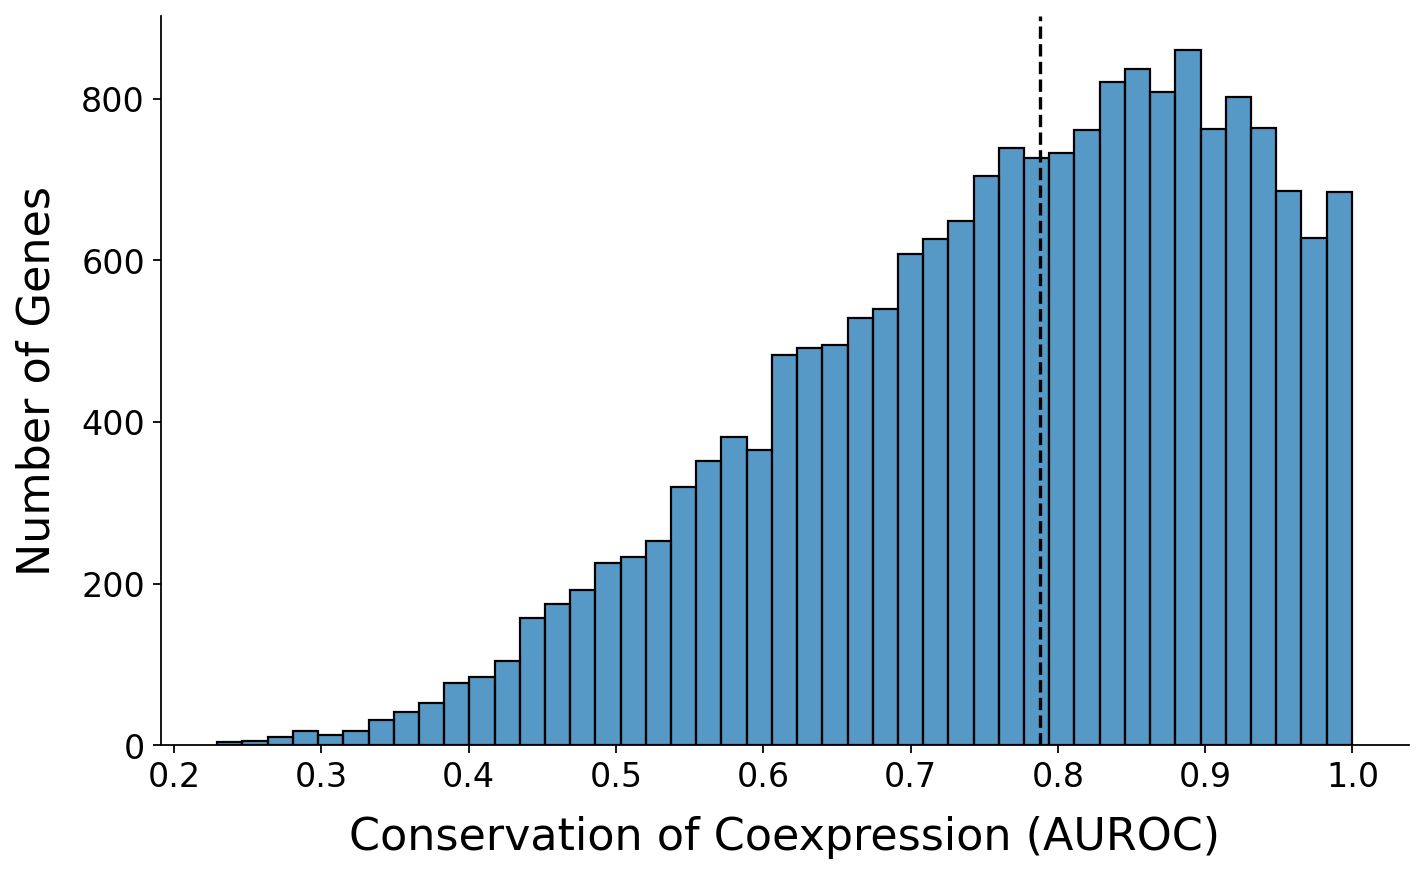

In [247]:


fig, ax = plt.subplots(figsize = (10,6))
fig.patch.set_facecolor('white')

g = sns.histplot(data = trimmed_all_gene_pairs_for_fc, x = 'Total Score')
plt.ylabel("Number of Genes", fontsize = 20,labelpad = 10)
plt.xlabel("Conservation of Coexpression (AUROC)", fontsize = 20, labelpad = 10)
plt.axvline(x=0.7877, color = 'k', linestyle= "--") 

sns.despine()
ax.grid(False)
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")

#plt.xlim(.5,.98)
#plt.ylim(.3,1)


#ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)


#ax.set_xticklabels(labels = meta_cluster_labels_from_1_to_9)
#plt.legend(fontsize= 14,markerscale = 2.5, title = 'Gene', title_fontsize = 20)
plt.savefig('/data/passala/Collaborator_Data/Sunil_Ken_root_Collab/2024_update/Plots/quality_of_single_cell_network.pdf',dpi = 800,bbox_inches='tight')

Next, we need an orthology mapping of our data. It should be all many to many gene pairs, formatted into 5 columns. 


Species_1-OrthoDB Gene ID , Species_2-OrthoDB Gene ID, Orthogroup, Species_1 Gene ID Used in your single cell data,Species_2 Gene ID Used in your single cell data

Next, use the two following functions to generate the list, dropping in your data and the generated coexpression network/networks in the first function

For the second function, drop in the results of your first function as well as whatever thresholds you'd like to use. Below are the ones we recommmend. 
